# SABR and Heston Model Calibration on SPY Options

This notebook demonstrates:

1. Downloading SPY option chain data from Yahoo Finance  
2. Cleaning and filtering the data  
3. Computing implied volatilities from market mid-prices  
4. Calibrating a SABR volatility smile for a single maturity  
5. Comparing market IV vs. SABR model IV
6. Calibrating a Heston for a single maturity  
7. Comparing market IV vs. Heston model IV


In [1]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from context import *

from scipy.stats import norm
from scipy.optimize import minimize

plt.style.use("default")
pd.set_option("display.max_rows", 20)

In [2]:
def bs_price(S, K, r, q, T, sigma, call=True):
    """
    Black–Scholes price for European call/put.
    S: spot
    K: strike
    r: continuously compounded risk-free rate
    q: dividend yield
    T: time to maturity (years)
    sigma: volatility
    call: True for call, False for put
    """
    if sigma <= 0 or T <= 0:
        return np.nan
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if call:
        price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    
    return price

from maths.maths import bisection_search
def implied_vol(target_price, S, K, r, q, T, call=True, tol=1e-6, max_iter=100):
    """
    Robust implied volatility solver using bisection.
    """
    # Guard rails
    if target_price <= 0 or T <= 0:
        return np.nan
    
    # Reasonable sigma bounds
    low, high = 1e-4, 5.0
    
    return bisection_search(
        func=lambda sigma: bs_price(S, K, r, q, T, sigma, call) - target_price,
        low=low,
        high=high,
        tolerance=tol,
        iters=max_iter
    )


In [3]:
# Configuration
TICKER = "SPY"
MIN_BID = 0.05          # filter illiquid options
RISK_FREE_RATE = 0.04   # rough constant rate; you can plug in a curve if you like
DIVIDEND_YIELD = 0.015  # rough SPY dividend yield

from helpers.yf_dataloader import YFDataLoader
data_helper = YFDataLoader(relative_output_path="yf_option_chain_spy.csv")
#data_helper.load_option_chain(TICKER, MIN_BID)
options_df = data_helper.retrieve_data()

options_df.head()


,expiry,strike,option_type,bid,ask,mid,lastPrice,volume,openInterest,time_to_expiry,days_to_expiry,forward,quote_date
0,2025-12-08,500.0,call,184.55,187.29,185.920,182.02,NaN,5,0.008219,3,688.12138,2025-12-05
1,2025-12-08,520.0,call,164.60,167.29,165.945,161.43,4.0,12,0.008219,3,688.12138,2025-12-05
2,2025-12-08,525.0,call,159.60,162.29,160.945,157.23,NaN,2,0.008219,3,688.12138,2025-12-05
3,2025-12-08,550.0,call,134.49,137.29,135.890,132.30,NaN,1,0.008219,3,688.12138,2025-12-05
4,2025-12-08,590.0,call,94.60,97.20,95.900,96.34,20.0,2,0.008219,3,688.12138,2025-12-05


In [4]:
# Get latest spot price
tk = yf.Ticker(TICKER)

S0 = 687.98 #float(tk.fast_info.last_price)

print(f"Using spot S0 = {S0:.2f}")

Using spot S0 = 687.98


In [5]:
# Choose the expiry closest to target_days
target_days = 120

expiry_candidates = options_df.groupby("expiry").agg(
    days=("days_to_expiry", "first")
).reset_index()

expiry_candidates["abs_diff"] = (expiry_candidates["days"] - target_days).abs()
chosen_expiry = expiry_candidates.sort_values("abs_diff").iloc[0]["expiry"]

print("Chosen expiry:", chosen_expiry)

slice_df = options_df[options_df["expiry"] == chosen_expiry].copy()
slice_df["time_to_expiry"] = slice_df["time_to_expiry"].astype(float).values  # ensure scalar per row
slice_df.head()


Chosen expiry: 2026-03-31 00:00:00


,expiry,strike,option_type,bid,ask,mid,lastPrice,volume,openInterest,time_to_expiry,days_to_expiry,forward,quote_date
3382,2026-03-31,345.0,call,342.37,345.64,344.005,343.55,1.0,3,0.317808,116,693.467915,2025-12-05
3383,2026-03-31,350.0,call,317.57,320.90,319.235,276.19,92.0,46,0.317808,116,693.467915,2025-12-05
3384,2026-03-31,355.0,call,319.62,322.98,321.300,323.00,1.0,3,0.317808,116,693.467915,2025-12-05
3385,2026-03-31,360.0,call,307.86,311.20,309.530,266.82,4.0,3,0.317808,116,693.467915,2025-12-05
3386,2026-03-31,365.0,call,269.58,272.61,271.095,241.90,1.0,1,0.317808,116,693.467915,2025-12-05


In [6]:
def add_implied_vols(df, S, r, q):
    df = df.copy()
    ivs = []
    
    for _, row in df.iterrows():
        K = row["strike"]
        T = row["time_to_expiry"]
        mid = row["mid"]
        call = (row["option_type"] == "call")
        
        vol = implied_vol(mid, S, K, r, q, T, call=call)
        ivs.append(vol)
    
    df["iv"] = ivs
    df = df.dropna(subset=["iv"])
    return df


slice_iv_df = add_implied_vols(slice_df, S0, RISK_FREE_RATE, DIVIDEND_YIELD)
slice_iv_df.head()


,expiry,strike,option_type,bid,ask,mid,lastPrice,volume,openInterest,time_to_expiry,days_to_expiry,forward,quote_date,iv
3389,2026-03-31,380.0,call,307.94,311.12,309.530,284.01,2.0,15,0.317808,116,693.467915,2025-12-05,0.339110
3393,2026-03-31,400.0,call,288.29,291.47,289.880,286.10,3.0,52,0.317808,116,693.467915,2025-12-05,0.363838
3395,2026-03-31,410.0,call,278.47,281.60,280.035,265.96,1.0,2,0.317808,116,693.467915,2025-12-05,0.356702
3399,2026-03-31,430.0,call,258.85,262.00,260.425,258.00,3.0,10,0.317808,116,693.467915,2025-12-05,0.352383
3403,2026-03-31,450.0,call,239.25,242.23,240.740,220.00,1.0,12,0.317808,116,693.467915,2025-12-05,0.329910


In [7]:
# Focus on calls around ATM (you can also use puts or both)
calls_df = slice_iv_df[slice_iv_df["option_type"] == "call"].copy()

# Filter to strikes in [0.6*S0, 1.4*S0] to avoid extreme wings
lower = 0.9 * S0
upper = 1.2 * S0
calls_df = calls_df[
    (calls_df["strike"] >= lower) &
    (calls_df["strike"] <= upper) &
    (calls_df["volume"] > 0)
].copy()

calls_df = calls_df.sort_values("strike")

print(f"Number of calls in slice after filtering: {len(calls_df)}")
calls_df.head()


Number of calls in slice after filtering: 40


,expiry,strike,option_type,bid,ask,mid,lastPrice,volume,openInterest,time_to_expiry,days_to_expiry,forward,quote_date,iv
3499,2026-03-31,620.0,call,78.61,79.16,78.885,79.35,3.0,518,0.317808,116,693.467915,2025-12-05,0.202138
3500,2026-03-31,625.0,call,74.30,74.88,74.590,76.53,699.0,1052,0.317808,116,693.467915,2025-12-05,0.199215
3501,2026-03-31,630.0,call,69.91,70.44,70.175,70.39,1.0,3108,0.317808,116,693.467915,2025-12-05,0.194490
3502,2026-03-31,635.0,call,65.72,66.20,65.960,63.32,12.0,746,0.317808,116,693.467915,2025-12-05,0.191219
3503,2026-03-31,640.0,call,61.38,61.89,61.635,62.06,1214.0,3601,0.317808,116,693.467915,2025-12-05,0.186343


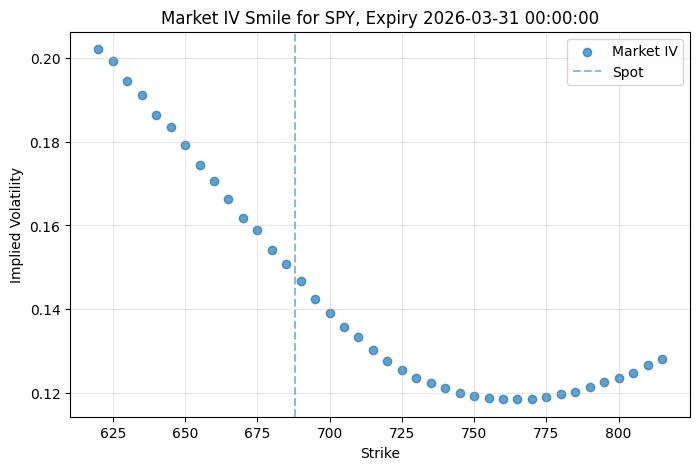

In [8]:
plt.figure(figsize=(8, 5))
plt.scatter(calls_df["strike"], calls_df["iv"], alpha=0.7, label="Market IV")
plt.axvline(S0, linestyle="--", alpha=0.5, label="Spot")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title(f"Market IV Smile for {TICKER}, Expiry {chosen_expiry}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## SABR Model

We use the lognormal SABR model (β–SABR) for a forward $F$ and strike $K$:

\begin{equation}
dF_t = \alpha_t F_t^\beta\, dW_t,
\qquad
d\alpha_t = \nu \alpha_t\, dZ_t,
\qquad
dW_t\, dZ_t = \rho\, dt.
\end{equation}

The parameters are:

- $\alpha$: initial volatility level  
- $\beta \in [0,1]$: CEV elasticity  
- $\rho$: correlation between forward and volatility  
- $\nu$: vol-of-vol  

The Hagan–Woodward asymptotic implied volatility approximation gives the Black implied vol
$\sigma_{\text{SABR}}(F,K,T)$.


For $K = F$, the SABR implied volatility simplifies to

\begin{equation}
\sigma_{\text{ATM}}
=
\frac{\alpha}{F^{\,1 - \beta}}
\left[
1
+
\left(
\frac{(2\beta - 1)\alpha^2}{24 F^{\,2 - 2\beta}}
+
\frac{\rho \beta \nu \alpha}{4 F^{\,1 - \beta}}
+
\frac{(2 - 3\rho^2)\nu^2}{24}
\right) T
\right].
\end{equation}

For $K \neq F$, define

\begin{equation}
\ln\left(\frac{F}{K}\right) = \ln FK,
\end{equation}

and

\begin{equation}
z 
=
\frac{\nu}{\alpha}
\,(F K)^{\frac{1 - \beta}{2}}
\,\ln FK.
\end{equation}

The function $x(z)$ is

\begin{equation}
x(z)
=
\ln
\left(
\frac{\sqrt{1 - 2\rho z + z^{2}} + z - \rho}{1 - \rho}
\right).
\end{equation}


Define

\begin{equation}
A =
\frac{\alpha}{
(FK)^{\frac{1 - \beta}{2}}
\left(
1 + \frac{(1-\beta)^2}{24} (\ln FK)^2
\right)
},
\end{equation}

\begin{equation}
B = \frac{z}{x(z)}.
\end{equation}

Then the Hagan Black implied volatility is

\begin{equation}
\sigma_{\text{SABR}}(F,K,T)
=
A B.
\end{equation}


In [9]:
def sabr_iv(K, F, T, alpha, beta, rho, nu):
    """
    Hagan SABR implied vol approximation (normal Black style).
    K: strike
    F: forward
    T: time to maturity
    alpha, beta, rho, nu: SABR params
    """
    if K <= 0 or F <= 0 or T <= 0:
        return np.nan

    if abs(F - K) < 1e-12:
        # ATM formula
        term1 = alpha / (F ** (1 - beta))
        term2 = 1 + (
            ((2 * beta - 1) * alpha**2) / (24 * F**(2 - 2*beta)) +
            (rho * beta * nu * alpha) / (4 * F**(1 - beta)) +
            ((2 - 3*rho**2) * nu**2) / 24
        ) * T
        return term1 * term2

    lnFK = np.log(F / K)
    z = (nu / alpha) * (F * K) ** ((1 - beta) / 2) * lnFK
    x_z = np.log((math.sqrt(1 - 2 * rho * z + z * z) + z - rho) / (1 - rho))

    A = alpha / ((F * K) ** ((1 - beta) / 2) * (1 + (1 - beta)**2 * lnFK**2 / 24))
    B = z / x_z
    vol = A * B

    # Apply time scaling
    return vol


In [10]:
def calibrate_sabr(strikes, ivs, F, T, beta_fixed=0.5):
    strikes = np.array(strikes)
    ivs = np.array(ivs)

    def objective(params):
        alpha, rho, nu = params
        beta = beta_fixed

        # Penalize invalid parameter regions
        if alpha <= 0 or nu <= 0 or not (-0.999 < rho < 0.999):
            return 1e6
        
        model_ivs = np.array([sabr_iv(K, F, T, alpha, beta, rho, nu) for K in strikes])
        if np.any(np.isnan(model_ivs)):
            return 1e6
        
        return np.mean((ivs - model_ivs)**2)

    # Rough initial guesses
    alpha0 = np.mean(ivs) * F**(1 - beta_fixed)
    rho0 = -0.3
    nu0 = 0.5

    x0 = np.array([alpha0, rho0, nu0])
    bounds = [
        (1e-4, 5.0),      # alpha
        (-0.999, 0.999),  # rho
        (1e-4, 5.0)       # nu
    ]

    res = minimize(objective, x0, bounds=bounds, method="L-BFGS-B")
    alpha_hat, rho_hat, nu_hat = res.x
    return {
        "alpha": alpha_hat,
        "beta": beta_fixed,
        "rho": rho_hat,
        "nu": nu_hat,
        "objective": res.fun,
        "success": res.success,
        "message": res.message
    }


In [11]:
# Use forward as a rough proxy: F ≈ S0 * exp((r - q) T)
T_slice = float(calls_df["time_to_expiry"].iloc[0])
F0 = S0 * math.exp((RISK_FREE_RATE - DIVIDEND_YIELD) * T_slice)

strikes = calls_df["strike"].values
market_ivs = calls_df["iv"].values

sabr_result = calibrate_sabr(strikes, market_ivs, F0, T_slice, beta_fixed=0.5)
sabr_result


{'alpha': np.float64(3.797237547880715),
 'beta': 0.5,
 'rho': np.float64(-0.6179956219319468),
 'nu': np.float64(1.46382943737823),
 'objective': np.float64(2.727541614715246e-07),
 'success': True,
 'message': 'CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL'}

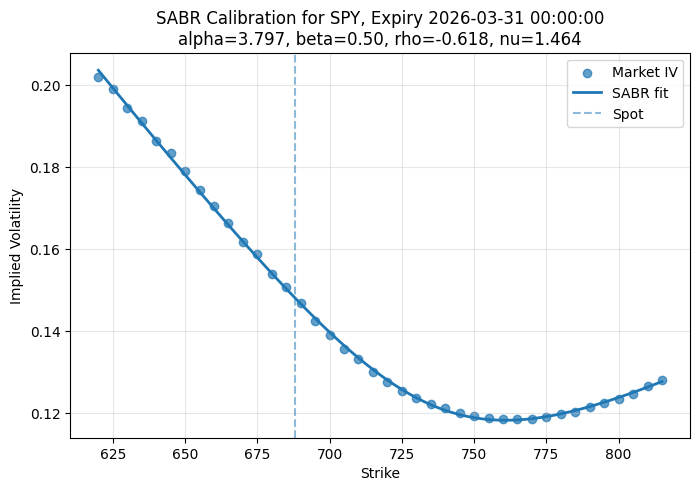

In [12]:
alpha_hat = sabr_result["alpha"]
beta_hat = sabr_result["beta"]
rho_hat = sabr_result["rho"]
nu_hat = sabr_result["nu"]

K_grid = np.linspace(strikes.min(), strikes.max(), 100)
sabr_ivs = [sabr_iv(K, F0, T_slice, alpha_hat, beta_hat, rho_hat, nu_hat) for K in K_grid]

plt.figure(figsize=(8, 5))
plt.scatter(strikes, market_ivs, label="Market IV", alpha=0.7)
plt.plot(K_grid, sabr_ivs, label="SABR fit", linewidth=2)
plt.axvline(S0, linestyle="--", alpha=0.5, label="Spot")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title(f"SABR Calibration for {TICKER}, Expiry {chosen_expiry}\n"
          f"alpha={alpha_hat:.3f}, beta={beta_hat:.2f}, rho={rho_hat:.3f}, nu={nu_hat:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Heston Model — Characteristic Function and Call Option Formula

We consider the Heston stochastic volatility model under the risk–neutral measure:

\begin{aligned}
dS_t &= (r - q)\, S_t \, dt + \sqrt{v_t}\, S_t \, dW^S_t, \\
dv_t &= \kappa(\theta - v_t)\, dt + \sigma \sqrt{v_t}\, dW^v_t, \\
\mathbb{E}[dW^S_t\, dW^v_t] &= \rho\, dt.
\end{aligned}

The European call price under the Heston model is

\begin{equation}
C(S_0,K,T)
=
S_0 e^{-qT} Q_1
-
K e^{-rT} Q_2.
\end{equation}

It depends on two probabilities:

\begin{equation}
Q_j
=
\frac{1}{2}
+
\frac{1}{\pi}
\int_0^\infty
\Re\!\left[
\frac{e^{- i u \ln K}\, \Psi_j(u)}
     {i u}
\right] du,
\qquad j = 1,2.
\end{equation}

These correspond to:

- $Q_1$: probability that the option finishes in the money under a modified measure  
- $Q_2$: risk–neutral probability used in the standard pricing formula

The characteristic function of $\ln S_T$ is

\begin{equation}
\Psi_j(u)
=
\exp\!\left(
C_j(u,T) + D_j(u,T)\, v_0 + i u\, x_0
\right),
\end{equation}

where

\begin{equation}
C_j(u,T)
=
(r - q) \, i u\, T
+ 
\frac{a}{\sigma^2}
\left[
(b_j - \rho\sigma i u + d_j)T
- 2 \ln\!\left(\frac{1 - g_j e^{d_j T}}{1 - g_j}\right)
\right],
\end{equation}

\begin{equation}
D_j(u,T)
=
\frac{b_j - \rho\sigma i u + d_j}{\sigma^2}
\left(
\frac{1 - e^{d_j T}}{1 - g_j e^{d_j T}}
\right).
\end{equation}

For  $j \in \{1,2\}$, the discriminant term is

\begin{equation}
d_j(u)
=
\sqrt{
(\rho\sigma i u - b_j)^2
+ \sigma^2 \left(u^2 - 2 i u\, u_j\right)
}.
\end{equation}

Define

\begin{equation}
g_j(u)
=
\frac{b_j - \rho\sigma i u + d_j(u)}
     {b_j - \rho\sigma i u - d_j(u)}.
\end{equation}

Where, using $x_0 = \ln S_0$, the auxiliary quantities are defined as:

\begin{equation}
a = \kappa\theta,
\qquad
b_1 = \kappa - \rho\sigma,
\qquad
b_2 = \kappa,
\end{equation}

\begin{equation}
u_1 = \tfrac{1}{2},
\qquad
u_2 = -\tfrac{1}{2}.
\end{equation}

In [13]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm

plt.rcParams["figure.dpi"] = 120


# ============================
#  Heston characteristic function (λ = 0)
# ============================

def heston_cf(idx, u, T, S0, r, q, kappa, theta, sigma, rho, v0):
    """
    Numerically-stable Heston characteristic function (modified form):
    - uses the "stable" branch choice equivalent to replacing d by -d
    - uses g_tilde and exp(-dT) in the log terms

    idx: 1 or 2 (Heston P1/P2)
    u: complex argument (can be real + 0j)
    """
    i = 1j
    x0 = np.log(S0)

    a = kappa * theta

    # Heston conventions (λ = 0)
    if idx == 1:
        b = kappa - rho * sigma
        u_shift = 0.5
    elif idx == 2:
        b = kappa
        u_shift = -0.5
    else:
        raise ValueError("idx must be 1 or 2")

    # ---- d(u) with stable branch (book: choose negative root / avoid branch cut) ----
    # z = (rho*sigma*i*u - b)^2 + sigma^2*(u^2 - 2*i*u*u_shift)
    z = (rho * sigma * i * u - b) ** 2 + sigma ** 2 * (u ** 2 - 2.0 * i * u * u_shift)

    d = np.sqrt(z)

    # book-style: take the root that makes the implementation stable.
    # Equivalent to "replace d by -d" compared to the original Heston form:
    # enforce Re(d) <= 0 (so exp(dT) decays; same as using exp(-dT) with Re(d)>=0)
    if np.real(d) > 0:
        d = -d

    # ---- modified g (uses -d branch) ----
    # g_tilde = (b - rho*sigma*i*u - d) / (b - rho*sigma*i*u + d)
    g = (b - rho * sigma * i * u - d) / (b - rho * sigma * i * u + d)

    # ---- C and D in the stable algebra (uses exp(-dT)) ----
    exp_neg_dT = np.exp(-d * T)

    # Avoid forming 1 - g*exp(...) in an unstable way
    one_minus_g_exp = 1.0 - g * exp_neg_dT
    one_minus_g = 1.0 - g

    C = (r - q) * i * u * T + (a / sigma ** 2) * (
        (b - rho * sigma * i * u - d) * T
        - 2.0 * np.log(one_minus_g_exp / one_minus_g)
    )

    D = ((b - rho * sigma * i * u - d) / sigma ** 2) * (
        (1.0 - exp_neg_dT) / one_minus_g_exp
    )

    return np.exp(C + D * v0 + i * u * x0)


# ============================
#  Risk-neutral probabilities Q1 & Q2
# ============================

def _Qj(j, S0, K, T, r, q, params):
    """
    Q1 und Q2 nach Heston via Fourier-Integral.
    """
    kappa, theta, sigma, rho, v0 = params
    i = 1j

    def integrand(j_idx):
        def f(u_real):
            u = u_real + 0j
            Phi = heston_cf(j_idx, u, T, S0, r, q, kappa, theta, sigma, rho, v0)
            num = np.exp(-i * u * np.log(K)) * Phi
            den = i * u
            return np.real(num / den)
        return f

    if j == 1:
        integral, _ = quad(integrand(1), 0.0, 100.0, limit=200)
    elif j == 2:
        integral, _ = quad(integrand(2), 0.0, 100.0, limit=200)
    else:
        raise ValueError("j muss 1 oder 2 sein")

    return 0.5 + integral / np.pi


def heston_call_price(S0, K, T, r, q, params):
    """
    Heston-Call:
        C = S0 e^{-qT} Q1 - K e^{-rT} Q2
    """
    Q1 = _Qj(1, S0, K, T, r, q, params)
    Q2 = _Qj(2, S0, K, T, r, q, params)
    return S0 * np.exp(-q * T) * Q1 - K * np.exp(-r * T) * Q2


# ============================
#  Heston-Kalibrierung (IV-Space)
# ============================

def calibrate_heston(S0, r, q, strikes, T, market_prices,
                        init_params=(1.0, 0.05, 0.5, -0.5, 0.05)):
    """
    Kalibriert Heston auf IVs.
    Gibt zurück:
        res, strikes_clean, market_ivs_clean
    """

    strikes = np.asarray(strikes, dtype=float)
    market_prices = np.asarray(market_prices, dtype=float)
    T = float(T)

    def objective(theta_vec):
        kappa, theta, sigma, rho, v0 = theta_vec

        # einfache Parameterrestriktionen
        model_prices = []

        for K in strikes:
            price_model = heston_call_price(
                S0, K, T, r, q, (kappa, theta, sigma, rho, v0)
            )
            model_prices.append(price_model)

        model_prices = np.array(model_prices)
        loss = np.mean((model_prices - market_prices) ** 2)
        #print("Current loss:", loss)
        return loss

    bounds = [
        (1e-3, 20.0),    # kappa
        (1e-4, 2.0),     # theta
        (1e-3, 3.0),     # sigma
        (-0.999, +0.999), # rho
        (1e-4, 2.0),     # v0
    ]

    res = minimize(
        objective,
        x0=np.array(init_params, dtype=float),
        method="L-BFGS-B",
        bounds=bounds,
        options={"maxiter": 400, "ftol": 1e-9, "gtol": 1e-8},
    )

    return res

Kalibriere Heston (IV-Space)...
Success: True | message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Objective (MSE in IV): 0.002524707343076027
Kalibrierte Parameter:
kappa = 6.8947871537
theta = 0.0123808222
sigma = 1.0592675987
rho   = -0.6369454389
v0    = 0.0530114416


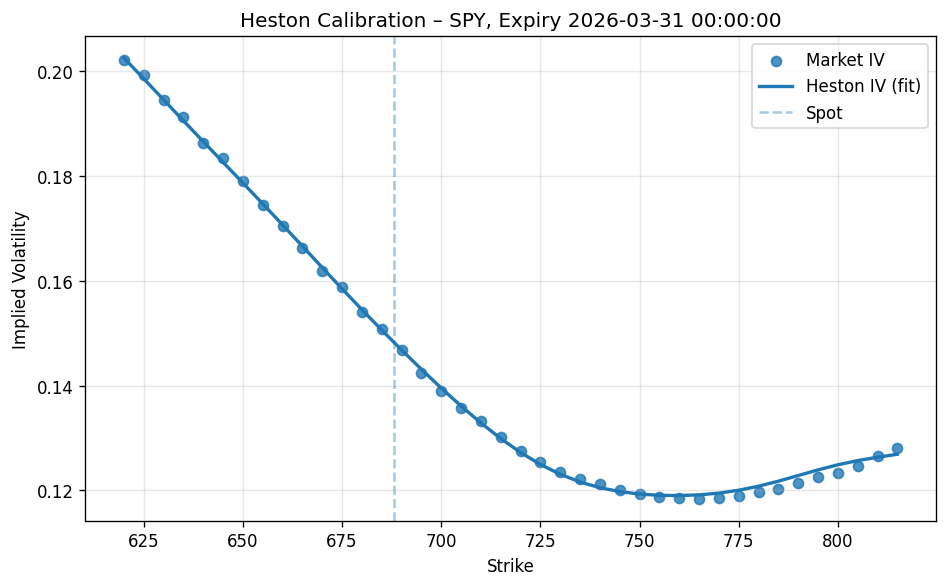

In [14]:

R = 0.04      # grobe Flat-Rate
Q = 0.015     # grober Div-Yield
TARGET_DAYS = 120

T_exp = float(calls_df["time_to_expiry"].iloc[0])

strikes = calls_df["strike"].values
market_prices = calls_df["mid"].values

init_params = (
    6.8947871513,
    0.0123808546,
    1.0592676002,
    -0.6369454449,
    0.0530114659,
)

# Kalibrierung
print("Kalibriere Heston (IV-Space)...")
res = calibrate_heston(
    S0, R, Q, strikes, T_exp, market_prices,
    init_params=init_params
)

print("Success:", res.success, "| message:", res.message)
print("Objective (MSE in IV):", res.fun)
kappa, theta, sigma, rho, v0 = res.x
print("Kalibrierte Parameter:")
print(f"kappa = {kappa:.10f}")
print(f"theta = {theta:.10f}")
print(f"sigma = {sigma:.10f}")
print(f"rho   = {rho:.10f}")
print(f"v0    = {v0:.10f}")

# Markt-IVs einmal berechnen 
market_ivs = np.array([ implied_vol(p, S0, K, R, Q, T_exp, call=True) for K, p in zip(strikes, market_prices) ])

# Modell-IVs für dieselben Strikes
model_ivs_cal = []
for K in strikes:
    C_model = heston_call_price(S0, K, T_exp, R, Q, (kappa, theta, sigma, rho, v0))
    iv_model = implied_vol(C_model, S0, K, R, Q, T_exp, call=True)
    model_ivs_cal.append(iv_model)
model_ivs_cal = np.array(model_ivs_cal)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(strikes, market_ivs, label="Market IV", alpha=0.8)
plt.plot(strikes, model_ivs_cal, label="Heston IV (fit)", linewidth=2)
plt.axvline(S0, linestyle="--", alpha=0.4, label="Spot")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title(f"Heston Calibration – {TICKER}, Expiry {chosen_expiry}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
TENORS = [60, 90, 120, 180, 360, 720]

call_df = options_df[options_df["option_type"] == "call"].copy()

# All available expiries with days-to-expiry
expiry_table = (
    options_df[["expiry", "days_to_expiry"]]
    .drop_duplicates()
    .sort_values("days_to_expiry")
)

chosen_expiries = []
used_expiries = set()

for target_days in TENORS:
    
    expiry_table["abs_diff"] = (expiry_table["days_to_expiry"] - target_days).abs()
    
    # Find the nearest expiry that we have NOT selected before
    for _, row in expiry_table.sort_values("abs_diff").iterrows():
        expiry = row["expiry"]
        if expiry not in used_expiries:
            used_expiries.add(expiry)
            chosen_expiries.append(expiry)
            break

print("Chosen expiries (unique):")
for e in chosen_expiries:
    print(e)

# Build slices:
slices = {e: call_df[call_df["expiry"] == e].copy() for e in chosen_expiries}





Chosen expiries (unique):
2026-01-30 00:00:00
2026-02-27 00:00:00
2026-03-31 00:00:00
2026-05-29 00:00:00
2026-12-18 00:00:00
2027-12-17 00:00:00


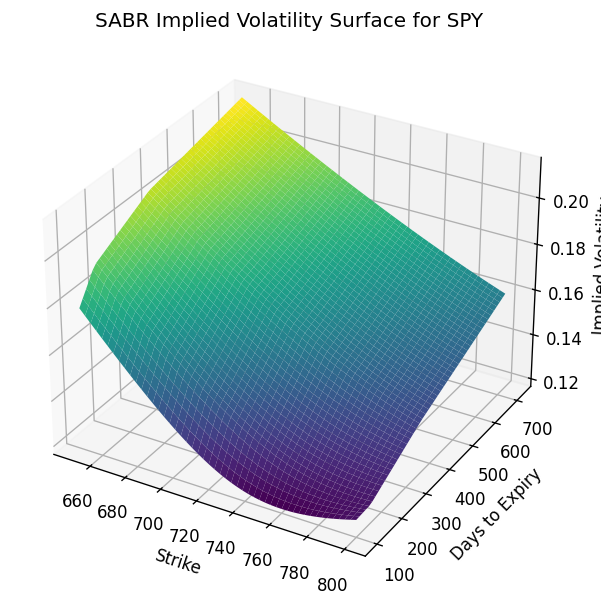

In [24]:
class SABRVolatilitySurface:
    def __init__(self, risk_free_rate, dividend_yield, initial_spot, tenor_grid = [60, 90, 120, 180, 360, 720]):
        self.tenor_grid = tenor_grid
        self.risk_free_rate = risk_free_rate
        self.dividend_yield = dividend_yield
        self.initial_spot = initial_spot
        self.sabr_params = {}  # Store SABR params per tenor
        
    def __calibrate_sabr(self, strikes, ivs, F, T, beta_fixed=0.5):
        strikes = np.array(strikes)
        ivs = np.array(ivs)

        def objective(params):
            alpha, rho, nu = params
            beta = beta_fixed

            # Penalize invalid parameter regions
            if alpha <= 0 or nu <= 0 or not (-0.999 < rho < 0.999):
                return 1e6
            
            model_ivs = np.array([sabr_iv(K, F, T, alpha, beta, rho, nu) for K in strikes])
            if np.any(np.isnan(model_ivs)):
                return 1e6
            
            return np.mean((ivs - model_ivs)**2)

        # Rough initial guesses
        alpha0 = np.mean(ivs) * F**(1 - beta_fixed)
        rho0 = -0.3
        nu0 = 0.5

        x0 = np.array([alpha0, rho0, nu0])
        bounds = [
            (1e-4, 5.0),      # alpha
            (-0.999, 0.999),  # rho
            (1e-4, 5.0)       # nu
        ]

        res = minimize(objective, x0, bounds=bounds, method="L-BFGS-B")
        alpha_hat, rho_hat, nu_hat = res.x
        return {
            "alpha": alpha_hat,
            "beta": beta_fixed,
            "rho": rho_hat,
            "nu": nu_hat,
            "objective": res.fun,
            "success": res.success,
            "message": res.message
        }
        
    def __select_time_slice(self, options_df, target_days):
        # All available expiries with days-to-expiry
        expiry_table = (
            options_df[["expiry", "days_to_expiry"]]
            .drop_duplicates()
            .sort_values("days_to_expiry")
        )

        chosen_expiries = []
        used_expiries = set()

        for target_days in self.tenor_grid:
            
            expiry_table["abs_diff"] = (expiry_table["days_to_expiry"] - target_days).abs()
            
            # Find the nearest expiry that we have NOT selected before
            for _, row in expiry_table.sort_values("abs_diff").iterrows():
                expiry = row["expiry"]
                if expiry not in used_expiries:
                    used_expiries.add(expiry)
                    chosen_expiries.append(expiry)
                    break


        # Build slices:
        slices = {e: call_df[call_df["expiry"] == e].copy() for e in chosen_expiries}
        return slices
        
    def fit_sabr(self, options_df):
        slices = self.__select_time_slice(options_df, self.tenor_grid)
        
        for expiry, slice_df in slices.items():
            slice_iv_df = add_implied_vols(slice_df, self.initial_spot, self.risk_free_rate, self.dividend_yield)
            
            # Filter to strikes in [0.9*S0, 1.2*S0] to avoid extreme wings
            lower = 650
            slice_iv_df = slice_iv_df[
                (slice_iv_df["strike"] >= lower) & 
                (slice_iv_df["volume"] > 0)
            ].copy()
            
            slice_iv_df = slice_iv_df.sort_values("strike")
            
            if len(slice_iv_df) < 5:
                print(f"Not enough data points for expiry {expiry}, skipping...")
                continue
            
            strikes = slice_iv_df["strike"].values
            market_ivs = slice_iv_df["iv"].values
            T_slice = float(slice_iv_df["time_to_expiry"].iloc[0])
            F0 = self.initial_spot * math.exp((self.risk_free_rate - self.dividend_yield) * T_slice)
            
            sabr_result = self.__calibrate_sabr(strikes, market_ivs, F0, T_slice, beta_fixed=0.5)
            self.sabr_params[expiry] = sabr_result
            
    def get_sabr_params(self, expiry):
        return self.sabr_params.get(expiry, None)
        
    def __find_surrounding_expiries(self, expiry):
        expiries = sorted(self.sabr_params.keys())
        lower_expiry = None
        upper_expiry = None
        for e in expiries:
            if e < expiry:
                lower_expiry = e
            elif e > expiry and upper_expiry is None:
                upper_expiry = e
        return lower_expiry, upper_expiry
    
    def __interpolate_in_time(
        self, 
        time_lower,
        vola_lower, 
        time_upper,
        vola_upper,      
        time_target
    ):
        """
        Linearly interpolate volatility in time dimension.
        """
        weight = (time_target - time_lower) / (time_upper - time_lower)
        vola_interp = vola_lower + weight * (vola_upper - vola_lower)
        return vola_interp
        
    
    def get_volatility(self, K, expiry):
        """
        Get SABR volatility for given strike and expiry using linear interpolation in time dimension
        and SABR interpolatio in strike dimension.
        """
        lower_expiry, upper_expiry = self.__find_surrounding_expiries(expiry)
        if lower_expiry is None or upper_expiry is None:
            return None  # Cannot interpolate   
        params_lower = self.sabr_params[lower_expiry]
        params_upper = self.sabr_params[upper_expiry]   
        T_lower = (lower_expiry - pd.Timestamp.today()).days / 365.0
        T_upper = (upper_expiry - pd.Timestamp.today()).days / 365.0
        T_target = (expiry - pd.Timestamp.today()).days / 365.0
        F_lower = self.initial_spot * math.exp((self.risk_free_rate - self.dividend_yield) * T_lower)
        F_upper = self.initial_spot * math.exp((self.risk_free_rate - self.dividend_yield) * T_upper)
        vola_lower = sabr_iv(K, F_lower, T_lower, 
                                params_lower["alpha"], 
                                params_lower["beta"], 
                                params_lower["rho"], 
                                params_lower["nu"])
        vola_upper = sabr_iv(K, F_upper, T_upper, 
                                params_upper["alpha"], 
                                params_upper["beta"], 
                                params_upper["rho"], 
                                params_upper["nu"])
        vola_interp = self.__interpolate_in_time(
            T_lower, vola_lower,
            T_upper, vola_upper,
            T_target
        )
        return vola_interp
    
    def get_volatility_surface(self, K_grid, expiry_grid):
        """
        Get SABR volatility surface on given strike and expiry grids.
        """
        vol_surface = np.zeros((len(expiry_grid), len(K_grid)))
        for i, expiry in enumerate(expiry_grid):
            for j, K in enumerate(K_grid):
                vol_surface[i, j] = self.get_volatility(K, expiry)
        return vol_surface
            
            
tenor_grid = np.linspace(60, 720, 6).astype(int).tolist()            
sabr_surface = SABRVolatilitySurface(
    risk_free_rate=RISK_FREE_RATE,
    dividend_yield=DIVIDEND_YIELD,
    initial_spot=S0,
    tenor_grid=TENORS
)
sabr_surface.fit_sabr(options_df=call_df)
strikes_grid = np.linspace(650, 800, 50)
expiry_grid = [pd.Timestamp.today() + pd.Timedelta(days=d) for d in np.linspace(100, 720, 50)]
vol_surface = sabr_surface.get_volatility_surface(strikes_grid, expiry_grid)    
# Plot volatility surface
X, Y = np.meshgrid(strikes_grid, [ (e - pd.Timestamp.today()).days for e in expiry_grid])
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, vol_surface, cmap='viridis', edgecolor='none')
ax.set_xlabel('Strike')
ax.set_ylabel('Days to Expiry')
ax.set_zlabel('Implied Volatility') 
ax.set_title(f'SABR Implied Volatility Surface for {TICKER}')
plt.show()
   


In [26]:
import numpy as np
import pandas as pd
import math
from scipy.optimize import minimize

class HestonVolatilitySurface:
    def __init__(self, risk_free_rate, dividend_yield, initial_spot,
                 tenor_grid=(60, 90, 120, 180, 360, 720)):
        self.risk_free_rate = risk_free_rate
        self.dividend_yield = dividend_yield
        self.initial_spot = initial_spot
        self.tenor_grid = list(tenor_grid)
        self.heston_params = None  # will hold np.array([kappa, theta, sigma, rho, v0])

        self.bounds = [
            (1e-3, 20.0),     # kappa
            (1e-4, 2.0),      # theta
            (1e-3, 3.0),      # sigma
            (-0.999, +0.999), # rho
            (1e-4, 2.0),      # v0
        ]

    # ---------- helper: select expiries near tenor_grid ----------
    def __select_time_slices(self, options_df):
        """
        Return dict expiry_str -> slice_df (calls only) for expiries
        closest to self.tenor_grid (in days), with unique expiries.
        """
        call_df = options_df[options_df["option_type"] == "call"].copy()

        expiry_table = (
            call_df[["expiry", "days_to_expiry"]]
            .drop_duplicates()
            .sort_values("days_to_expiry")
        )

        chosen_expiries = []
        used_expiries = set()

        for target_days in self.tenor_grid:
            expiry_table["abs_diff"] = (expiry_table["days_to_expiry"] - target_days).abs()

            # pick nearest unused expiry
            for _, row in expiry_table.sort_values("abs_diff").iterrows():
                e = row["expiry"]
                if e not in used_expiries:
                    used_expiries.add(e)
                    chosen_expiries.append(e)
                    break

        slices = {e: call_df[call_df["expiry"] == e].copy() for e in chosen_expiries}
        return slices

    # ---------- Heston multi-tenor calibration ----------
    def __calibrate_heston(self, time_to_strikes, time_to_market_prices, init_params):
        """
        time_to_strikes: dict T -> np.array of strikes
        time_to_market_prices: dict T -> np.array of mid prices (same length as strikes)
        """

        def objective(theta_vec):
            kappa, theta, sigma, rho, v0 = theta_vec

            # simple parameter sanity
            if kappa <= 0 or theta <= 0 or sigma <= 0 or v0 <= 0:
                return 1e10
            if not (-0.999 < rho < 0.999):
                return 1e10

            model_prices = []
            market_prices = []

            for T, K_arr in time_to_strikes.items():
                mkt_arr = time_to_market_prices[T]
                for K, p_mkt in zip(K_arr, mkt_arr):
                    p_model = heston_call_price(
                        self.initial_spot, K, T,
                        self.risk_free_rate, self.dividend_yield,
                        (kappa, theta, sigma, rho, v0)
                    )
                    model_prices.append(p_model)
                    market_prices.append(p_mkt)

            model_prices = np.array(model_prices)
            market_prices = np.array(market_prices)
            loss = np.mean((model_prices - market_prices) ** 2)
            return loss

        res = minimize(
            objective,
            x0=np.array(init_params, dtype=float),
            method="L-BFGS-B",
            bounds=self.bounds,
            options={"maxiter": 400, "ftol": 1e-9}
        )
        return res

    # ---------- public: fit ----------
    def fit_heston(self, options_df, init_params=(1.0, 0.05, 0.5, -0.5, 0.05)):
        slices = self.__select_time_slices(options_df)
        time_to_strikes = {}
        time_to_prices = {}

        for expiry, slice_df in slices.items():
            # ensure T column (years) exists
            if "T" not in slice_df.columns:
                slice_df["expiry_dt"] = pd.to_datetime(slice_df["expiry"])
                today = pd.Timestamp.today().normalize()
                slice_df["T"] = (slice_df["expiry_dt"] - today).dt.days / 365.0

            T_slice = float(slice_df["T"].iloc[0])

            # Filter to strikes around spot to avoid wings
            lower = 0.8 * self.initial_spot
            upper = 1.2 * self.initial_spot
            slice_df = slice_df[
                (slice_df["strike"] >= lower) &
                (slice_df["strike"] <= upper) &
                (slice_df["volume"] > 0)
            ].copy()

            slice_df = slice_df.sort_values("strike")

            if len(slice_df) < 5:
                print(f"Not enough data points for expiry {expiry}, skipping...")
                continue

            strikes = slice_df["strike"].values
            market_prices = slice_df["mid"].values

            time_to_strikes[T_slice] = strikes
            time_to_prices[T_slice] = market_prices

        if not time_to_strikes:
            raise RuntimeError("No valid slices to calibrate on.")

        res = self.__calibrate_heston(
            time_to_strikes,
            time_to_prices,
            init_params
        )
        if res.success:
            self.heston_params = res.x
            print("Heston calibration success. Params:", self.heston_params)
        else:
            print("Heston calibration failed:", res.message)
            self.heston_params = None

    # ---------- public: single-point vol ----------
    def get_volatility(self, K, expiry):
        """
        Get Heston implied vol for given strike K and expiry (pd.Timestamp).
        """
        if self.heston_params is None:
            return np.nan

        kappa, theta, sigma, rho, v0 = self.heston_params
        T = (expiry - pd.Timestamp.today().normalize()).days / 365.0
        if T <= 0:
            return np.nan

        C_model = heston_call_price(
            self.initial_spot, K, T,
            self.risk_free_rate, self.dividend_yield,
            (kappa, theta, sigma, rho, v0)
        )
        iv_model = implied_vol(
            C_model,
            self.initial_spot,
            K,
            self.risk_free_rate,
            self.dividend_yield,
            T,
            call=True
        )
        return iv_model

    # ---------- public: full surface ----------
    def get_volatility_surface(self, K_grid, expiry_grid):
        vol_surface = np.zeros((len(expiry_grid), len(K_grid)))
        for i, expiry in enumerate(expiry_grid):
            for j, K in enumerate(K_grid):
                vol_surface[i, j] = self.get_volatility(K, expiry)
        return vol_surface


heston_surface = HestonVolatilitySurface(
    risk_free_rate=RISK_FREE_RATE,
    dividend_yield=DIVIDEND_YIELD,
    initial_spot=S0,
    tenor_grid=TENORS
)

init_params = (
    0.01713417, 2., 0.45545583, -0.78975708, 0.0286834 
)

heston_surface.fit_heston(options_df=call_df, init_params=init_params)


/var/folders/rt/cfghmpkd1pb4rlc7k2jjd7s40000gn/T/ipykernel_4857/2553258668.py:98: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(integrand(1), 0.0, 100.0, limit=200)
/var/folders/rt/cfghmpkd1pb4rlc7k2jjd7s40000gn/T/ipykernel_4857/2553258668.py:100: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral, _ = quad(integrand(2), 0.0, 100.0, limit=200)


Heston calibration success. Params: [ 0.01711     1.99990411  0.46781947 -0.78435669  0.02983595]


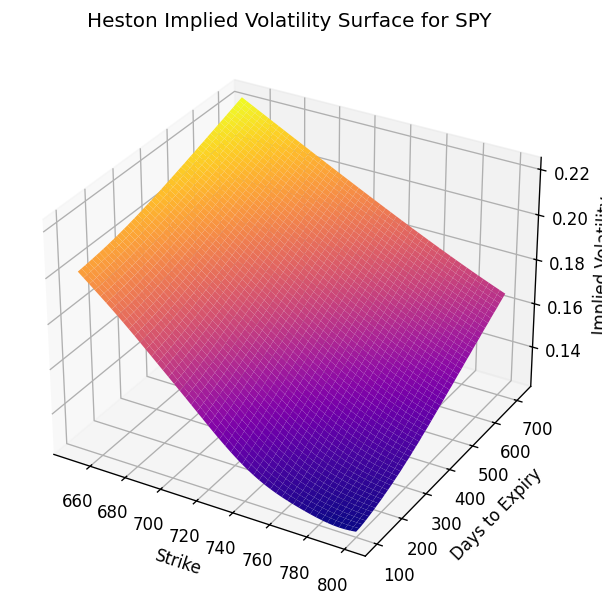

In [27]:
strikes_grid = np.linspace(650, 800, 50)
expiry_grid = [pd.Timestamp.today() + pd.Timedelta(days=d) for d in np.linspace(100, 720, 50)]
vol_surface_heston = heston_surface.get_volatility_surface(strikes_grid, expiry_grid)    
# Plot volatility surface
X, Y = np.meshgrid(strikes_grid, [ (e - pd.Timestamp.today()).days for e in expiry_grid])
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, vol_surface_heston, cmap='plasma', edgecolor='none')
ax.set_xlabel('Strike')
ax.set_ylabel('Days to Expiry')
ax.set_zlabel('Implied Volatility') 
ax.set_title(f'Heston Implied Volatility Surface for {TICKER}')
plt.show()  